In [1]:
!nvidia-smi

Fri Mar 14 01:42:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import VGG16 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow import keras # Access to stuff for model
from keras.callbacks import ReduceLROnPlateau # ---------------------------------
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Load data

In [4]:
# Load CIFAR-100 dataset
(X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

# Split (8000) of training data into temporary set
X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
print(f"X_temp.shape: {X_temp.shape}\n")

# Split temp data into equal validation (4000) and testing (4000) data
X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
print(f"X_temp_val.shape: {X_temp_val.shape}")
print(f"y_temp_val.shape: {y_temp_val.shape}")
print(f"X_temp_test.shape: {X_temp_test.shape}")
print(f"y_temp_test.shape: {y_temp_test.shape}\n")

# Split test data into validation (5000) and testing (5000)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

# Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
X_val = np.concatenate((X_val, X_temp_val), axis=0)
y_val = np.concatenate((y_val, y_temp_val), axis=0)
X_test = np.concatenate((X_test, X_temp_test), axis=0)
y_test = np.concatenate((y_test, y_temp_test), axis=0)

print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"y_val.shape: {y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"y_test.shape: {y_test.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)


labels[11985].shape: (1,)
imgs[11985].shape: (32, 32, 3)


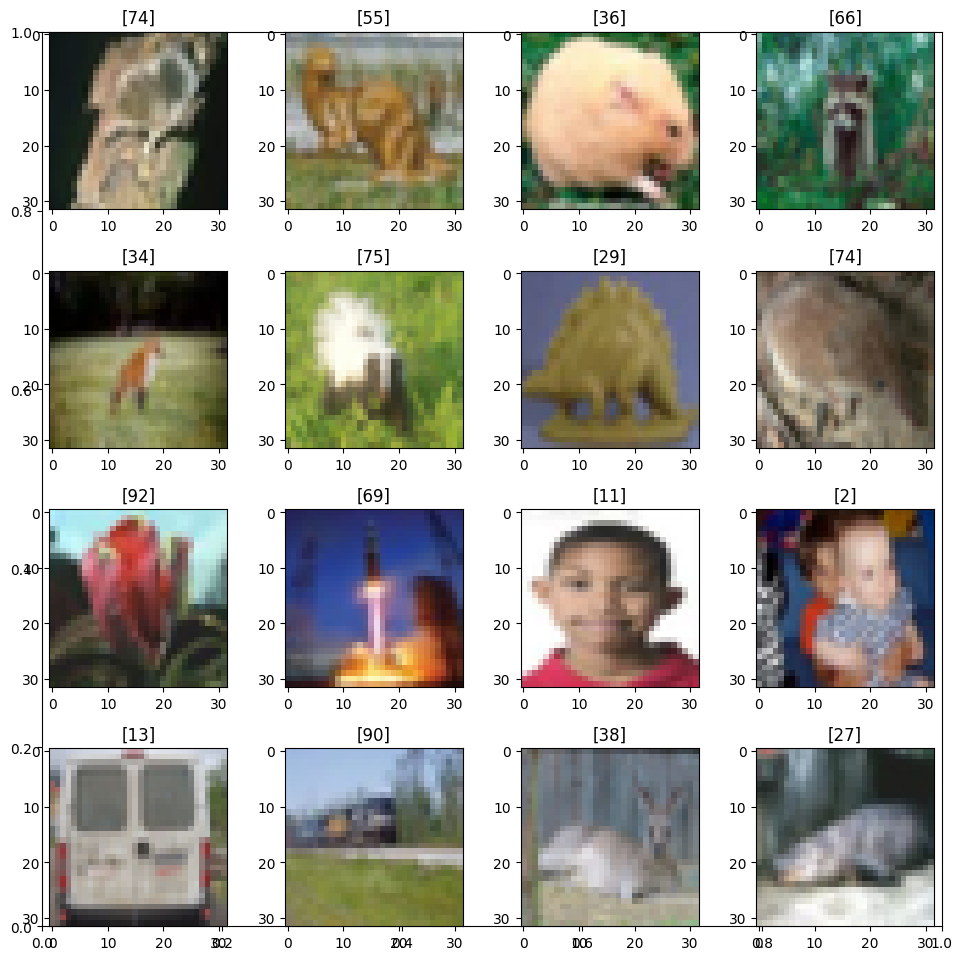

In [5]:
idxs_disp = []
def display_imgs(imgs, labels,norm_version):
    plt.subplots(figsize=(10,10))
    if norm_version == 0:
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            idxs_disp.append(k)
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.title(labels[k])
            plt.imshow(imgs[k])
    else:
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = idxs_disp[i]
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.title(labels[k])
            plt.imshow(imgs[k])
    plt.tight_layout()
    plt.show()

display_imgs(X_train, y_train, 0)

labels[11985].shape: (1,)
imgs[11985].shape: (32, 32, 3)


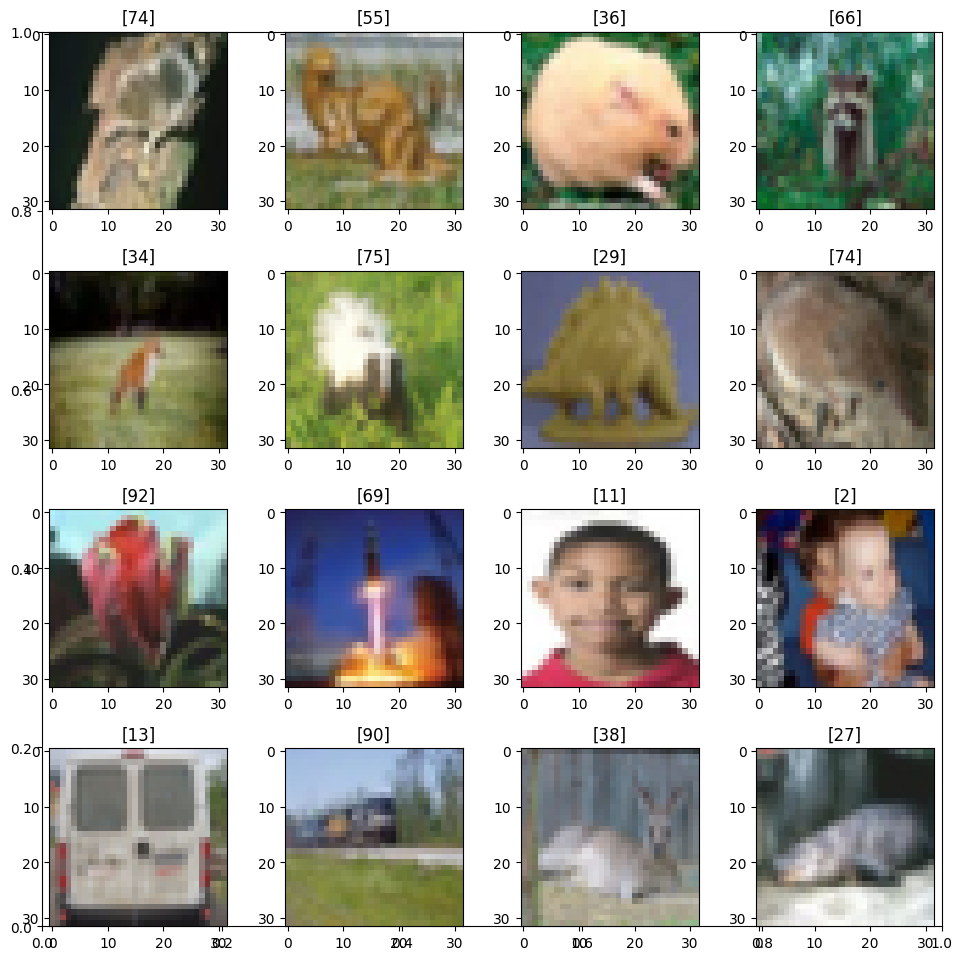

In [6]:
# Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
display_imgs(X_train, y_train,1)

In [7]:
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(50000).batch(64)
#val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64)

labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
               'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
               'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
               'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
               'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
               'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
               'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
               'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
               'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
               'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
               'tractor']

# Create TensorFlow datasets

batch_size = 64
train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size))

val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
               .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                  tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
               .batch(batch_size))

test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                 .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                    tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                 .batch(batch_size))

print(f"Training dataset:\n {train_dataset}")
for img, lbl in train_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nValidation dataset:\n {val_dataset}")
for img, lbl in val_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl
print(f"\nTesting dataset:\n {test_dataset}")
for img, lbl in test_dataset.take(1):
    #if isinstance(batch, tuple) and len(batch) == 2:
    print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
    print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
    del img,lbl

Training dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)


<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


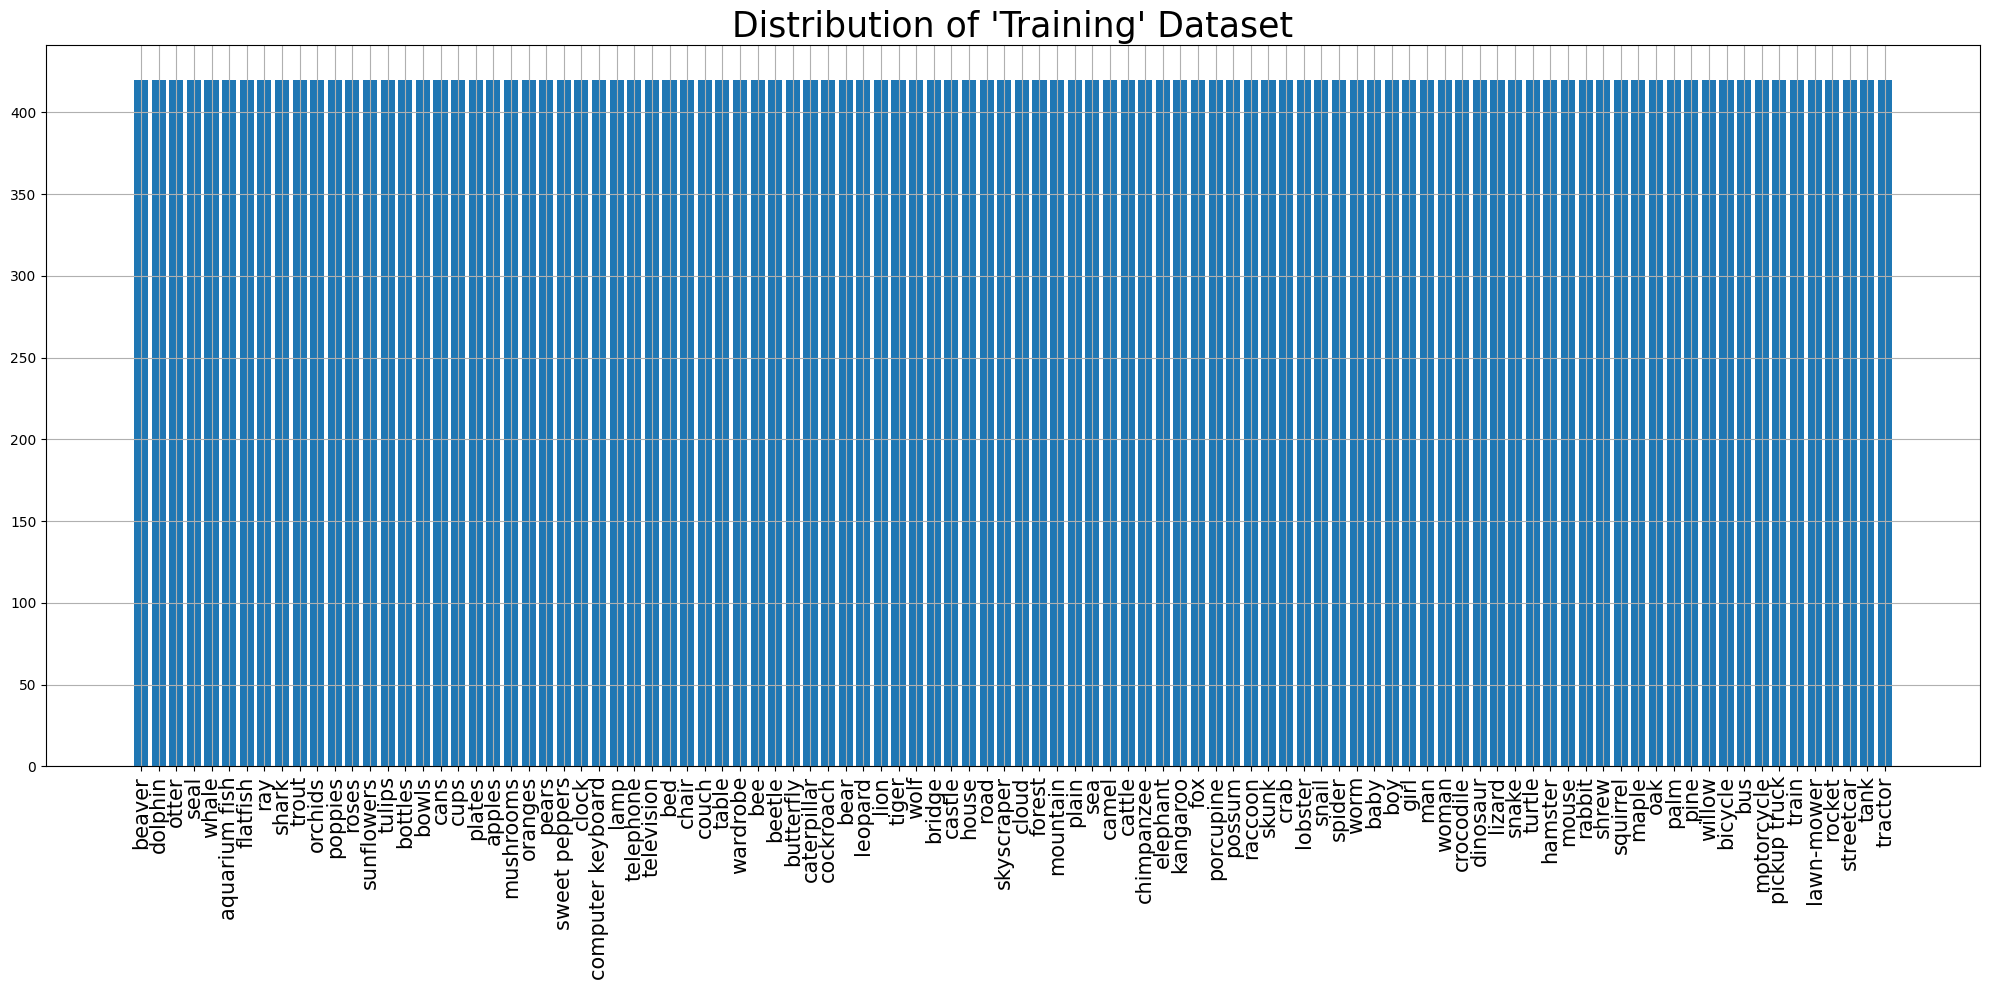

<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


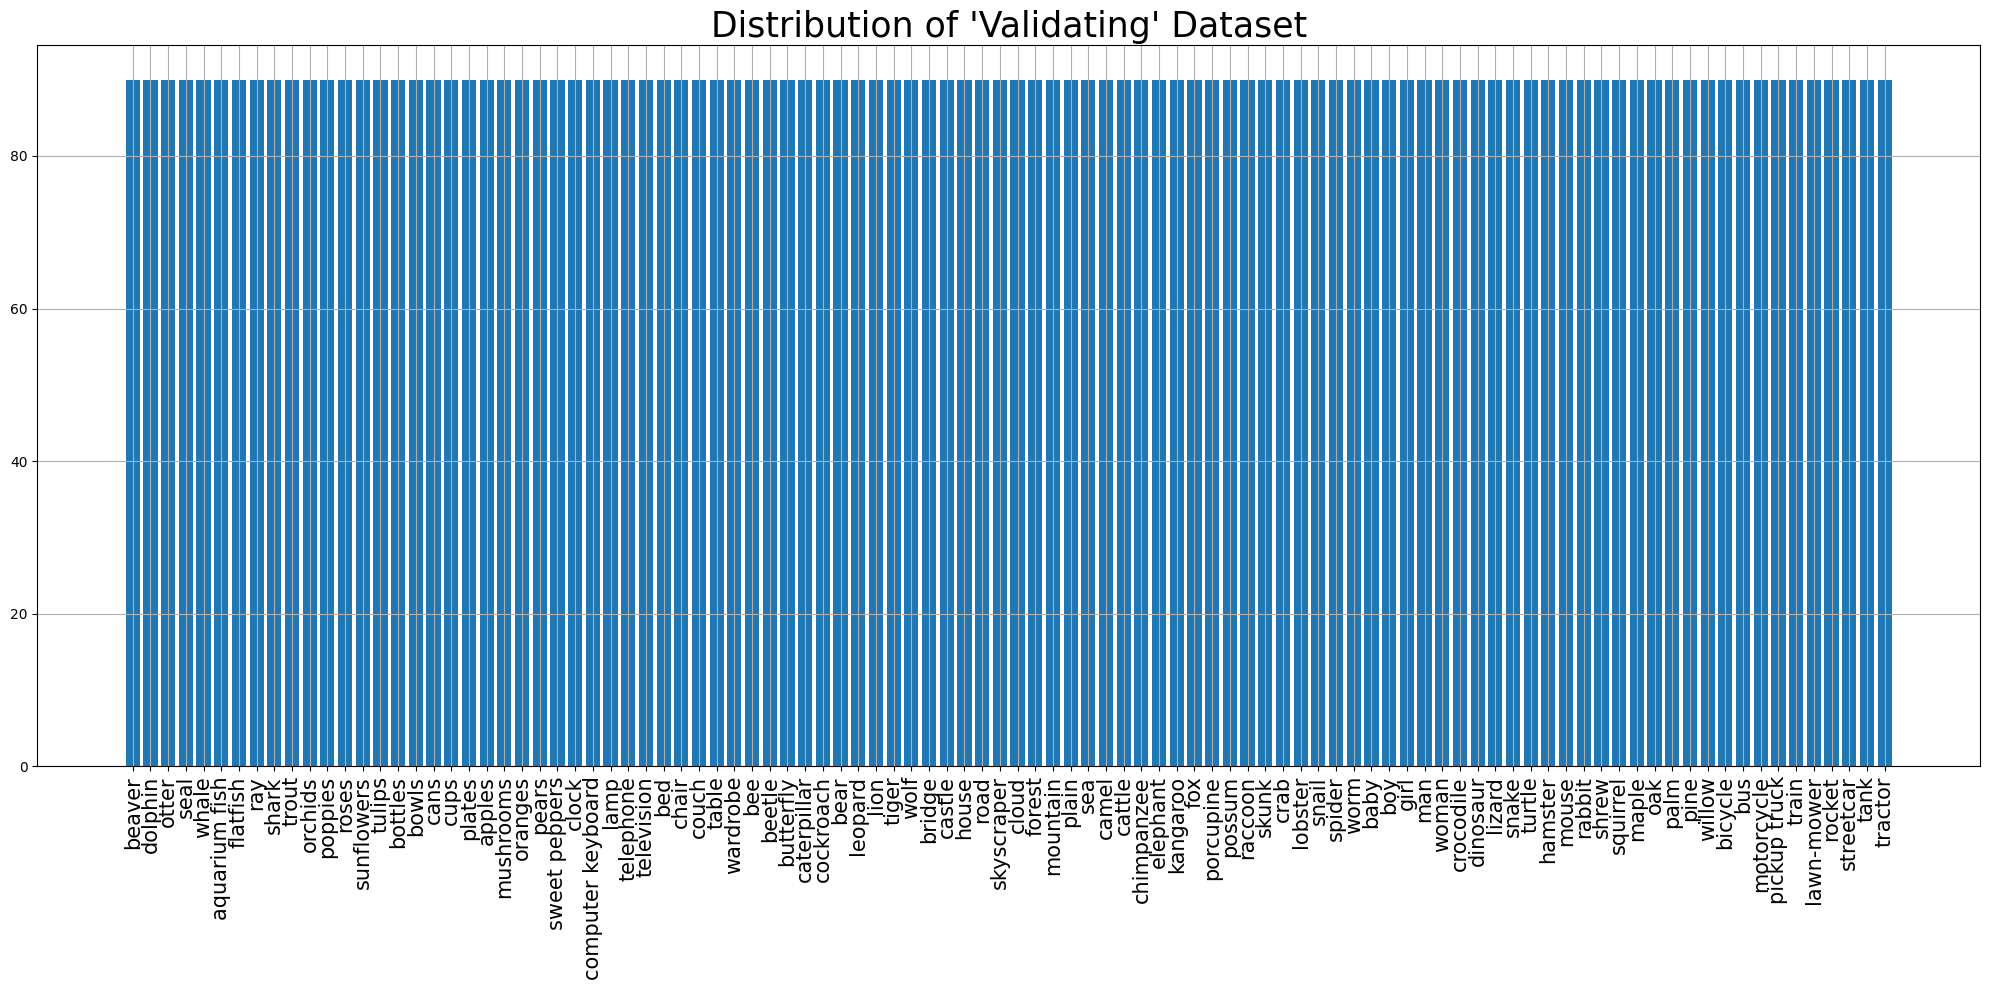

<ipython-input-8-b584abab378c>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


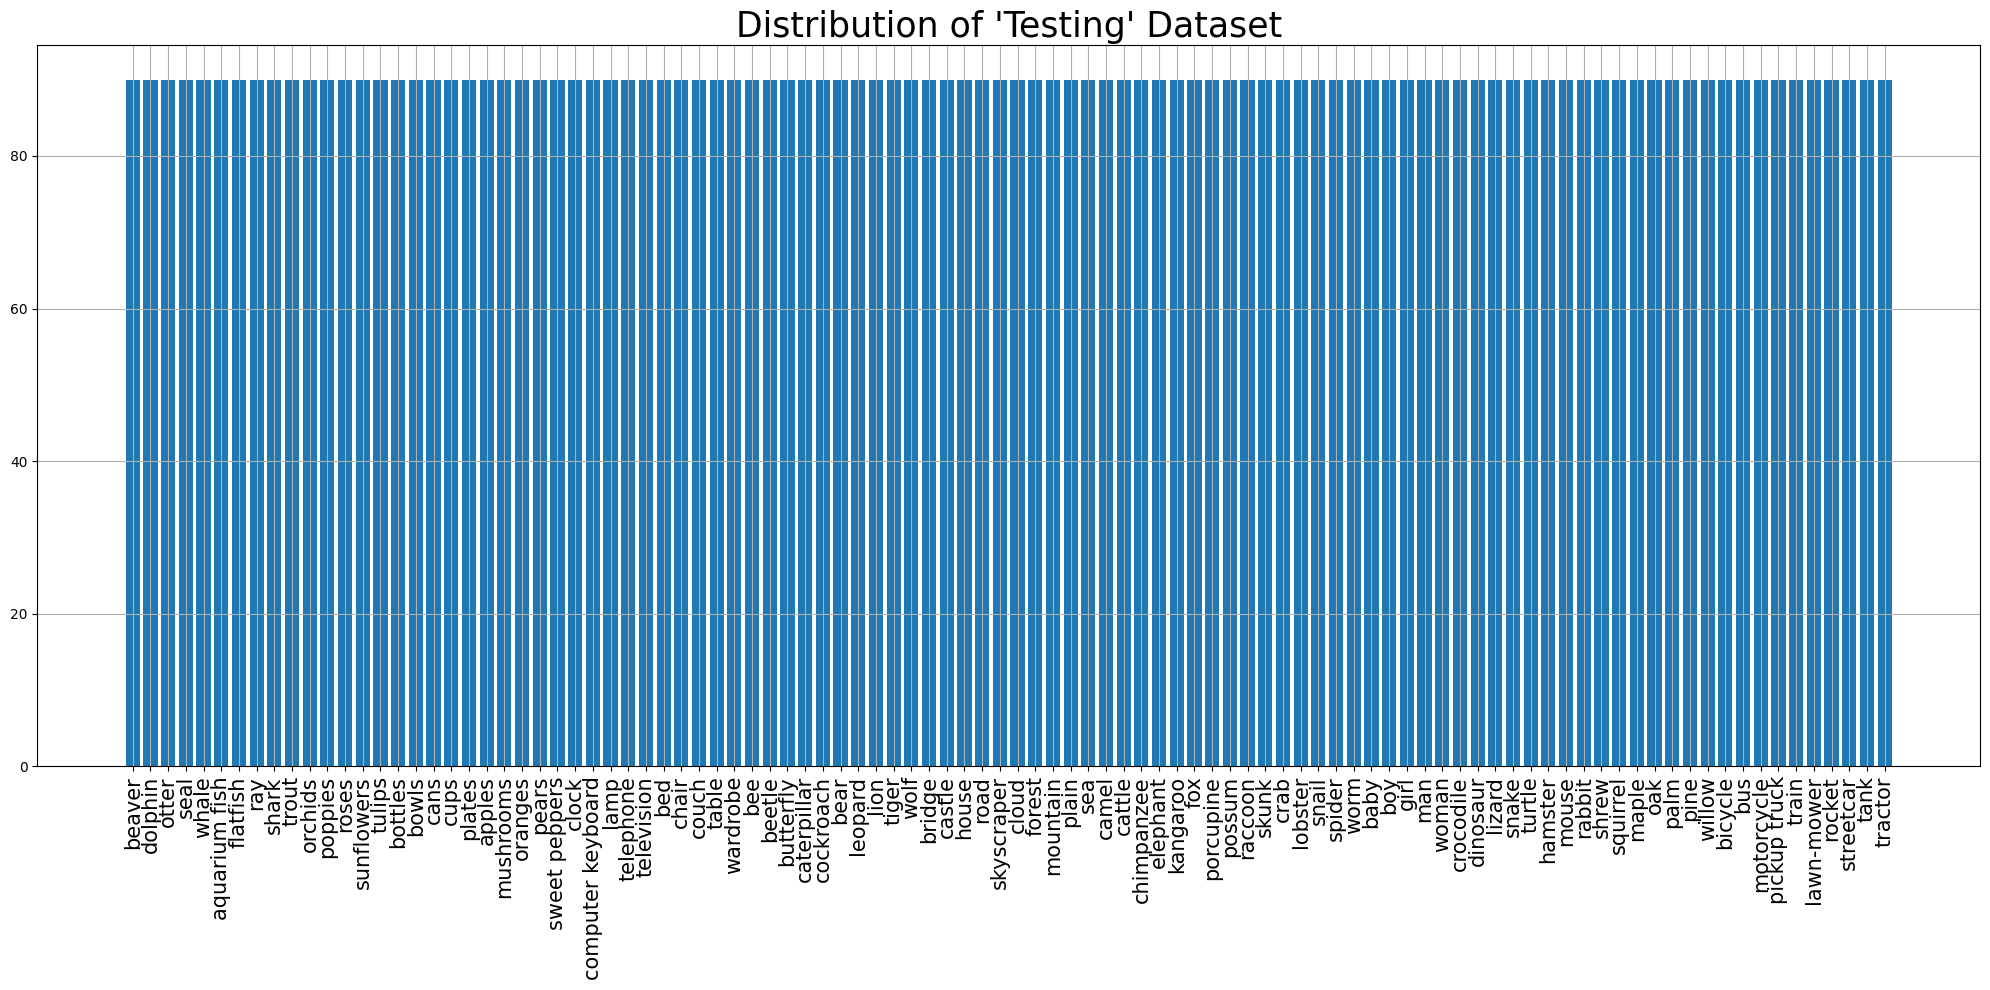

In [8]:
def class_distrib(y, labels_names, dataset_name):
    counts = pd.DataFrame(data=y).value_counts().sort_index()
    #print(f"counts:\n{counts}")
    fig, ax = plt.subplots(figsize=(20,10))
    ax.bar(labels_names, counts)
    ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
    plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
    plt.grid()
    plt.tight_layout()
    plt.show()
class_distrib(y_train, labels_names, "Training")
class_distrib(y_val, labels_names, "Validating")
class_distrib(y_test, labels_names, "Testing")

In [9]:
#print(train_dataset.len())

# Define Model

In [10]:
def build_vgg16():
    model = models.Sequential([
        # First block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Second block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Third block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Fourth block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Fifth block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=2),

        # Flatten the output and add fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Build the VGG16 model from scratch
model = build_vgg16()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,301,860 (85.07 MB)

 Trainable params: 22,301,860 (85.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train Model & Track Training/Validation Error

In [11]:
# reduceLR = ReduceLROnPateau(monitor='val_accuracy', factor=0.1, patience=3, min_delta=0.01, mode="auto")

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 102s 114ms/step - accuracy: 0.0091 - loss: 4.6322 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 2/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0089 - loss: 4.6056 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 3/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0088 - loss: 4.6057 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 4/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0076 - loss: 4.6058 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 5/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0082 - loss: 4.6058 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 6/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0083 - loss: 4.6058 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 7/20
657/657 ━━━━━━━━━━━━━━━━━━━━ 58s 88ms/step - accuracy: 0.0084 - loss: 4.6058 - val_accuracy: 0.0100 - val_loss: 4.6052
Epoch 8/20
359/657 ━━━━━━━━━━━━━━━━━━━━ 24s 83ms/step - accuracy: 0.0083 - loss: 4.6058

KeyboardInterrupt: 

# Plot Training & Validation Error

In [ ]:
# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

# Evaluate Model on Test Data

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Generate Confusion Matrix

In [ ]:
# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Finally, display the hist DataFrame.
hist

### Use pre-trained model

In [ ]:
#### Set up model
# Load VGG16 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
vgg_base.trainable = False

# Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
model = models.Sequential([
    vgg_base,  # VGG16 base model
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Train Model & Track Training/Validation Error

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Finally, display the hist DataFrame.
hist

### Fine-tune model

In [ ]:
#### Adapt model
# Unfreeze last conv block (last 4 layers) - to adapt them to CIFAR-100
for layer in vgg_base.layers[-4:]:
    layer.trainable = True # Allow layers to be updated

# Compile again w/ lower learning rate (prevents destroying learned features)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Train Model & Track Training/Validation Error

# Train the model
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history_fine_tune.history['loss'])+1)
train_loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']
train_acc = history_fine_tune.history['accuracy']
val_acc = history_fine_tune.history['val_accuracy']

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history_fine_tune.history)
hist['epoch'] = history_fine_tune.epoch

# Finally, display the hist DataFrame.
hist

In [ ]:
#### Set up model
# Load VGG16 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
vgg_base.trainable = False

# Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
model = models.Sequential([
    vgg_base,  # VGG16 base model
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Train Model & Track Training/Validation Error

# Train the model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

# Extract loss and accuracy
epochs = range(1,len(history.history['loss'])+1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Finally, display the hist DataFrame.
hist

In [ ]:
#### Adapt model
# Unfreeze last conv block (last 4 layers) - to adapt them to CIFAR-100
for layer in vgg_base.layers[-4:]:
    layer.trainable = True # Allow layers to be updated

# Compile again w/ lower learning rate (prevents destroying learned features)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

#### Train Model & Track Training/Validation Error

# Train the model
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

#### Plot Training & Validation Error

# Extract loss and accuracy
epochs = range(1,len(history_fine_tune.history_fine_tune['loss'])+1)
train_loss = history_fine_tune.history_fine_tune['loss']
val_loss = history_fine_tune.history_fine_tune['val_loss']
train_acc = history_fine_tune.history_fine_tune['accuracy']
val_acc = history_fine_tune.history_fine_tune['val_accuracy']

def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
    # Plot Training and Validation Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

#### Evaluate Model on Test Data

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc*100:.2f}%")

#### Generate Confusion Matrix

# Get predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test.flatten()

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
# Create a DataFrame from the history of the training and store the epoch values.
hist = pd.DataFrame(history_fine_tune.history)
hist['epoch'] = history_fine_tune.epoch

# Finally, display the hist DataFrame.
hist